In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Check for available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using device: {device}")
print(num_gpus)

# Load and preprocess the data
print("Start: Loading and preprocessing the data...")
df = pd.read_csv('pendulum_data.csv')  # Replace with your CSV file path
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
data_tensor = torch.tensor(scaled_df, dtype=torch.float32).to(device)
print("Finish: Data loading and preprocessing.")


Using device: cuda
2
Start: Loading and preprocessing the data...
Finish: Data loading and preprocessing.


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, TensorDataset, DistributedSampler
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===========================
# Deep Autoencoder for Dimensionality Reduction using DDP
# ===========================

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

# Initialize the distributed training process
def setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"  # Ensure the port is free
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

# Clean up after training
def cleanup():
    dist.destroy_process_group()

def train_autoencoder(rank, world_size, data_tensor, encoding_dim=2, num_epochs=20, batch_size=256):
    setup(rank, world_size)
    torch.cuda.set_device(rank)  # Assign each process a specific GPU

    # Move data to GPU
    dataset = TensorDataset(data_tensor)
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    input_dim = data_tensor.shape[1]
    model = Autoencoder(input_dim, encoding_dim).to(rank)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        sampler.set_epoch(epoch)  # Ensures different shuffling per epoch
        for batch in dataloader:
            batch = batch[0].to(rank)  # Move batch to GPU
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
        if rank == 0:  # Only print from one process
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    cleanup()  # Clean up distributed processes

if __name__ == "__main__":
    world_size = torch.cuda.device_count()  # Get number of GPUs
    data_tensor = torch.randn(10000, 20)  # Example random data
    mp.spawn(train_autoencoder, args=(world_size, data_tensor), nprocs=world_size, join=True)

    print("Finish: Autoencoder training.")


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/tljh/user/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/tljh/user/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train_autoencoder' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/tljh/user/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/tljh/user/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train_autoencoder' on <module '__main__' (built-in)>


ProcessExitedException: process 1 terminated with exit code 1

In [3]:
# ===========================
# Dynamic Time Warping (DTW) using Torch
# ===========================
print("Start: DTW computation...")
def dtw_distance(ts1, ts2):
    DTW = torch.full((len(ts1) + 1, len(ts2) + 1), float('inf'), device=device)
    DTW[0, 0] = 0
    for i in tqdm(range(1, len(ts1) + 1), desc="DTW Iteration for ts1"):
        for j in range(1, len(ts2) + 1):
            cost = torch.abs(ts1[i - 1] - ts2[j - 1])
            DTW[i, j] = cost + torch.min(DTW[i - 1, j], DTW[i, j - 1], DTW[i - 1, j - 1])
    return DTW[len(ts1), len(ts2)]

print("Finish: DTW computation.")

Start: DTW computation...
Finish: DTW computation.


Start: K-Means clustering...


K-Means iterations: 100%|██████████| 100/100 [00:00<00:00, 601.88it/s]


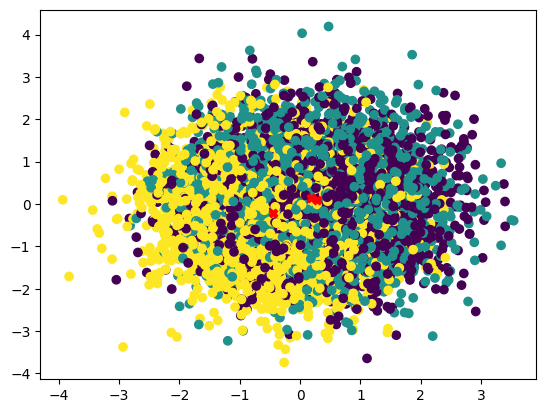

Finish: K-Means clustering.


In [5]:
# ===========================
# K-Means Clustering with Torch
# ===========================
print("Start: K-Means clustering...")
def kmeans(X, k, max_iters=100):
    centroids = X[torch.randint(0, X.size(0), (k,))]
    for i in tqdm(range(max_iters), desc="K-Means iterations"):
        distances = torch.cdist(X, centroids)
        labels = torch.argmin(distances, dim=1)
        new_centroids = torch.stack([X[labels == i].mean(dim=0) for i in range(k)])
        if torch.all(centroids == new_centroids):
            print(f"K-Means converged at iteration {i+1}")
            break
        centroids = new_centroids
    return centroids, labels

k = 3
centroids, labels = kmeans(data_tensor, k)
plt.scatter(data_tensor[:, 0].cpu(), data_tensor[:, 1].cpu(), c=labels.cpu())
plt.scatter(centroids[:, 0].cpu(), centroids[:, 1].cpu(), marker='X', color='red')
plt.show()
print("Finish: K-Means clustering.")

Start: Fourier Transform analysis...


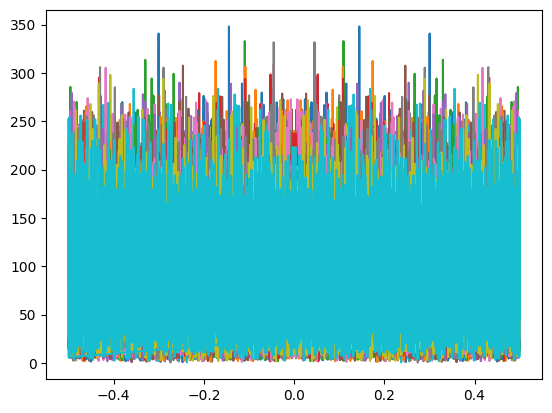

Finish: Fourier Transform analysis.


In [6]:
# ===========================
# Fourier Transform for Periodicity Analysis
# ===========================
print("Start: Fourier Transform analysis...")
def fourier_transform(X):
    fft_result = torch.fft.fft(X, dim=0)
    freqs = torch.fft.fftfreq(X.shape[0])
    return freqs, fft_result.abs()

freqs, fft_values = fourier_transform(data_tensor)
plt.plot(freqs.cpu().numpy(), fft_values.cpu().numpy())
plt.show()
print("Finish: Fourier Transform analysis.")

In [8]:
# ===========================
# LSTM-Based Predictive Modeling
# ===========================
print("Start: Training LSTM model...")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

input_size = data_tensor.shape[1]
model = LSTMModel(input_size, hidden_size=50, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
for epoch in tqdm(range(num_epochs), desc="Training LSTM"):
    model.train()
    optimizer.zero_grad()
    output = model(data_tensor.unsqueeze(1))
    loss = criterion(output, data_tensor[:, 0].unsqueeze(1))
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Finish: LSTM model training.")

Start: Training LSTM model...


Training LSTM:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [9]:
# ===========================
# Anomaly Detection with Autoencoder
# ===========================
print("Start: Anomaly detection using Autoencoder...")
with torch.no_grad():
    reconstructions = model(data_tensor)
    loss_per_point = torch.mean((data_tensor - reconstructions) ** 2, dim=1)
anomalies = loss_per_point > loss_per_point.mean() + 2 * loss_per_point.std()
plt.scatter(data_tensor[:, 0].cpu(), data_tensor[:, 1].cpu(), c=anomalies.cpu())
plt.show()
print("Finish: Anomaly detection using Autoencoder.")


Start: Anomaly detection using Autoencoder...


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0